<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


In [56]:
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import cv2
from skimage import io

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "dark", 
        color_codes = True,
        font_scale = 1.5)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [57]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

### Reading images from datasets

In [58]:
from ipynb.fs.full.GradProject_NB1 import read_training_data

In [59]:
training_data, label_dict = read_training_data()
print(" Dataset dimensions:", training_data.shape)

Fetching label '.DS_Store'
Fetching label 'airplanes'
Fetching label 'bear'
Fetching label 'blimp'
	Gray image ('blimp_0022.jpg') was loaded, converting to RGB
Fetching label 'comet'
	Gray image ('comet_0006.jpg') was loaded, converting to RGB
	Gray image ('comet_0011.jpg') was loaded, converting to RGB
	Gray image ('comet_0013.jpg') was loaded, converting to RGB
	Gray image ('comet_0021.jpg') was loaded, converting to RGB
	Gray image ('comet_0036.jpg') was loaded, converting to RGB
	Gray image ('comet_0038.jpg') was loaded, converting to RGB
	Gray image ('comet_0041.jpg') was loaded, converting to RGB
	Gray image ('comet_0049.jpg') was loaded, converting to RGB
	Gray image ('comet_0052.jpg') was loaded, converting to RGB
	Gray image ('comet_0053.jpg') was loaded, converting to RGB
	Gray image ('comet_0057.jpg') was loaded, converting to RGB
	Gray image ('comet_0058.jpg') was loaded, converting to RGB
Fetching label 'crab'
	Gray image ('crab_0045.jpg') was loaded, converting to RGB
Fet

<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [60]:
def show(image):
    io.imshow(image)

### Presentation of dataset

The learning set consists of a total of 1,501 images, of 20 different types and of possibly different sizes (i.e.,numbers of pixels).  Each image is represented as 3-d array with the first two dimensions corresponding tothe row and column pixels and third dimension to the color.

Below is three of the represented categories displayed:

<Figure size 1296x576 with 0 Axes>

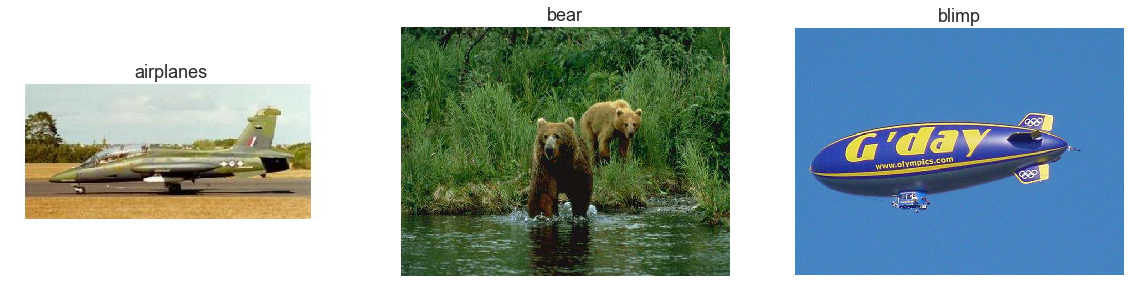

In [61]:
# Displaying the three images from the first three categories in the training set
image_by_label = training_data.groupby("Label").agg({"Image": lambda x: list(x[0])})
image_by_label["Image"] = image_by_label["Image"].apply(np.array)
img1, img2, img3 = image_by_label["Image"].iloc[0], image_by_label["Image"].iloc[1], image_by_label["Image"].iloc[2]
[label1, label2, label3] = image_by_label.index[0:3]

# Plotting images
plt.figure(figsize=(18,8))
f, axes = plt.subplots(figsize=(20,10), ncols=3, nrows=1)

axes[0].imshow(img1)
axes[1].imshow(img2)
axes[2].imshow(img3)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].title.set_text(label_dict[label1])
axes[1].title.set_text(label_dict[label2])
axes[2].title.set_text(label_dict[label3]);

#### Class frequencies

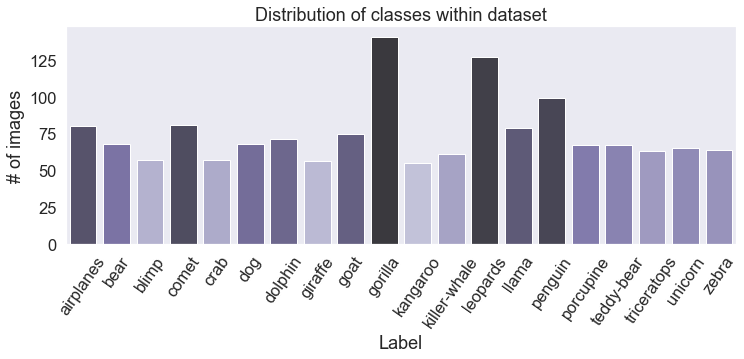

In [62]:
plt.figure(figsize=(12,4))

labels = training_data.groupby("Label")["Image"].count()

pal = sns.color_palette("Purples_d", len(labels))
rank = labels.argsort().argsort()

ax = sns.barplot(x=[label_dict[label] for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within dataset")
plt.ylabel("# of images")
plt.xlabel("Label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);

The distribution is quite balanced, but there are some classes that are more represented than others, e.g. *Gorilla* and *Leopards*. If this becomes an issue, one might consider to down-sample the training set.

#### Graphical summaries of the sizes of the images in addition to pixel intensities

<Figure size 1080x360 with 0 Axes>

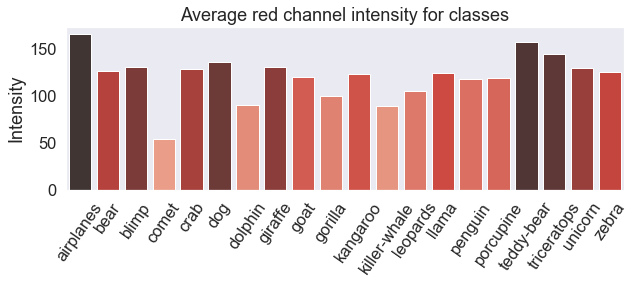

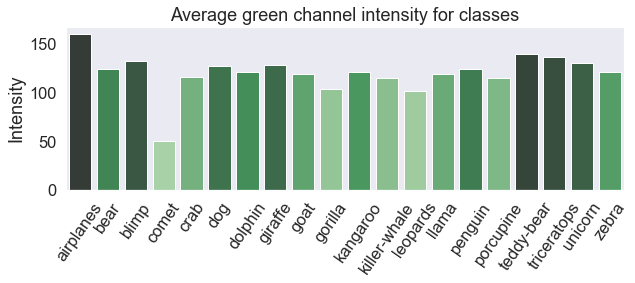

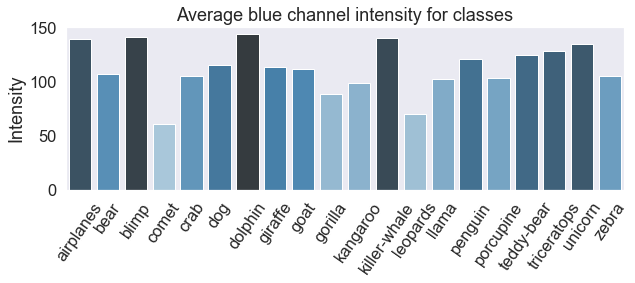

In [11]:
plt.figure(figsize=(15,5))
def calculate_channel_average(img, channel):
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

# Calculating channel average over all labels
red_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="R") for img in s])}).reset_index()
green_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="G") for img in s])}).reset_index()
blue_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="B") for img in s])}).reset_index()

def plot_channel_intensity_barplot(df, channel):
    # Plotting individual plots for channel intensities
    title_dict = {"r": "red", "g": "green", "b": "blue"}
    palet_dict = {"r": "Reds_d", "g": "Greens_d", "b": "Blues_d"}
    plt.figure(figsize=(10,3))

    values = df["Image"].values
    pal = sns.color_palette(palet_dict[channel], len(values))
    rank = values.argsort().argsort()
    ax = sns.barplot(x=[label_dict[label] for label in df["Label"]], y=values, palette=np.array(pal[::-1])[rank])
    
    plt.ylabel("Intensity")
    plt.title(f"Average {title_dict[channel]} channel intensity for classes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=55)

plot_channel_intensity_barplot(red_channel_average, "r")
plot_channel_intensity_barplot(green_channel_average, "g")
plot_channel_intensity_barplot(blue_channel_average, "b");

#### Plotting all channel distribtions together

In [12]:
def set_type_array(channel, df):
    
    df["type"] = [channel for _ in range(len(df))]

set_type_array("red", red_channel_average)
set_type_array("green", green_channel_average)
set_type_array("blue", blue_channel_average)

channel_averages = pd.concat([red_channel_average, green_channel_average, blue_channel_average])

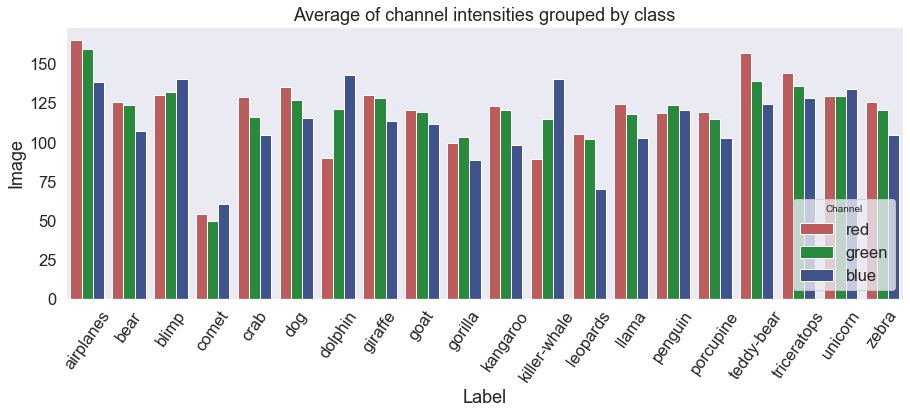

In [13]:
plt.figure(figsize=(15,5))

colors = [[0.8, 0.3, 0.3], [0.1, 0.6, 0.2], [0.2, 0.3, 0.6] ]

ax = sns.barplot(x=[label_dict[label] for label in channel_averages["Label"]], y="Image", hue="type", data=channel_averages, palette=colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);
plt.xlabel("Label")
plt.title("Average of channel intensities grouped by class")
ax.legend(title="Channel",loc="lower right");

#### Distribution of image sizes

Plotting the distribution of image sizes (number of values in a image-vector: $height*width*3$)

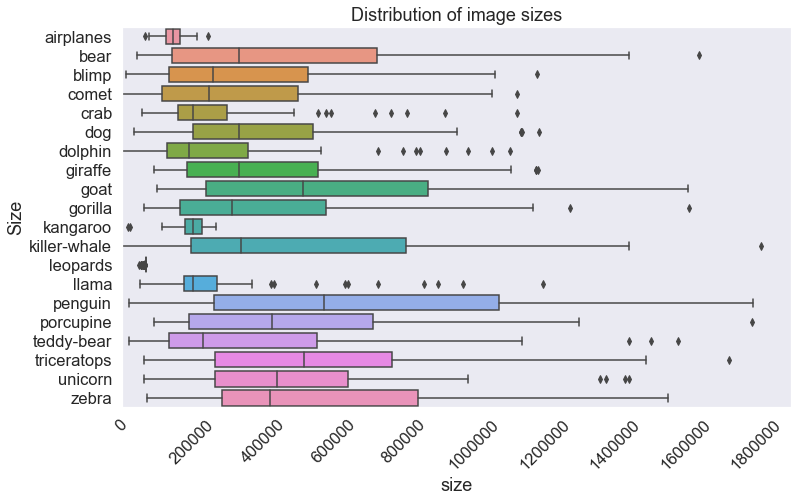

In [55]:
plt.figure(figsize=(12,7))

training_data["size"] = training_data["Image"].apply(np.size)

ax = sns.boxplot(y=[label_dict[label] for label in training_data["Label"]], x="size", data=training_data, orient="h")
plt.title("Distribution of image sizes")
plt.xticks(np.arange(0, 1900000, 200000), rotation=45)
plt.xlim(0, 1900000)
plt.ylabel("Label");
plt.ylabel("Size");

We see that the distribution of image sizes among the different classes appear to be different. Many of the distributions stretches over similar areas, especially between 300,000 and 700,000. A couple of the categories such as; `airplanes`, `kangaroo` and `leopards`, have very small distributions, which indicates that size might be a good feature. 

In [15]:
training_data[training_data["Label"]==12]["size"].describe()

count    6.100000e+01
mean     7.232922e+05
std      1.237948e+06
min      5.278500e+04
25%      2.380800e+05
50%      4.468500e+05
75%      8.352000e+05
max      9.437184e+06
Name: size, dtype: float64

### Preprocessing

In [16]:
def get_trimmed_image(image):
    """
    Returns image without white border if such border exists.
    If not, returns original image
    """
    imagePIL = Image.fromarray(np.array(image))
    bg = Image.new(imagePIL.mode, imagePIL.size, imagePIL.getpixel((0,0)))
    diff = ImageChops.difference(imagePIL, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        trimmed_img = imagePIL.crop(bbox)
        return np.array(trimmed_img)
    return image

In [17]:
# Trim every image 
training_data['Image'] = training_data['Image'].apply(get_trimmed_image)

Rescaling to h: 316.43171219187207, w: 415.8789563762306


<Figure size 1296x576 with 0 Axes>

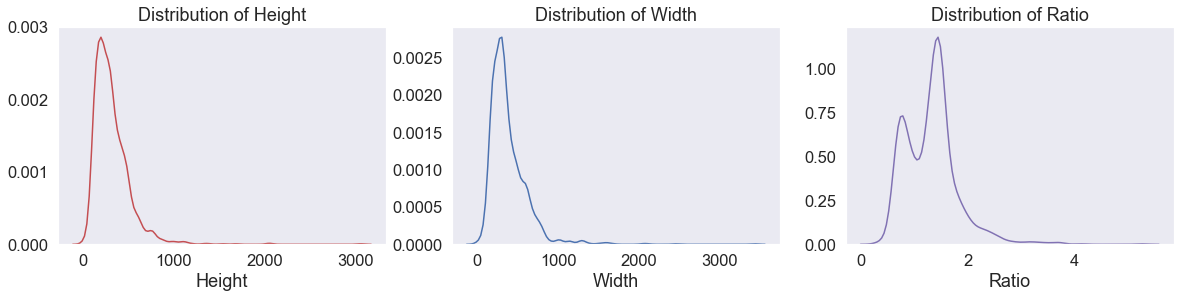

In [18]:
height = training_data["Image"].apply(len)
width = training_data["Image"].apply(lambda x: len(x[0]))
ratio = width/height

# Plotting distributions
plt.figure(figsize=(18,8))

f, axes = plt.subplots(figsize=(20,4), ncols=3, nrows=1)

sns.distplot(height, hist=False, ax=axes[0], color="r")
sns.distplot(width, hist=False, ax=axes[1], color="b")
sns.distplot(ratio, hist=False, ax=axes[2], color="m")

axes[0].set_xlabel("Height")
axes[1].set_xlabel("Width")
axes[2].set_xlabel("Ratio")

axes[0].title.set_text('Distribution of Height')
axes[1].title.set_text('Distribution of Width')
axes[2].title.set_text('Distribution of Ratio')

# Choosing mean heigth and ratio to derive width, to rescale images
mean_ratio = np.mean(ratio)
scale_height = np.mean(height)
scale_width = scale_height * mean_ratio

scaling_size = (int(scale_width), int(scale_height))

print(f"Rescaling to h: {scale_height}, w: {scale_width}");

In [51]:
def get_scaling_size(data):
    """
    Calculating scaling size
    """
    height = data["Image"].apply(len)
    width = data["Image"].apply(lambda x: len(x[0]))
    ratio = width/height
    
    mean_ratio = np.mean(ratio)
    scale_height = np.mean(height)
    scale_width = scale_height * mean_ratio

    return (int(scale_width), int(scale_height))

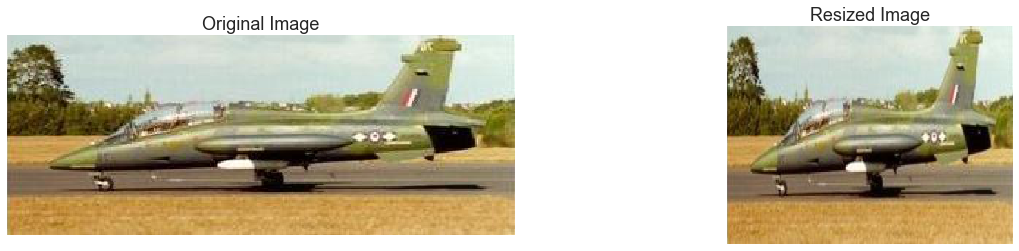

In [19]:
def resize_image(image, size):
    """
    Resizes image to a fixed size
    """
    return cv2.resize(image, size, interpolation = cv2.INTER_AREA)

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)

original_image = training_data.Image[0]
resized_img = resize_image(original_image, scaling_size)

axes[0].imshow(original_image)
axes[1].imshow(resized_img)

axes[0].title.set_text('Original Image')
axes[1].title.set_text('Resized Image')
axes[0].axis('off')
axes[1].axis('off');

##### Scaling images based on width, height and aspect-ratio distribution

In [20]:
training_data["Scaled_Image"] = training_data["Image"].apply(resize_image, args=(scaling_size,))

### Feature extraction

#### Proposed features:

* Image size
* Avg red-channel intensity
* Avg green-channel intensity
* Avg blue-channel intensity
* Aspect-ratio
* Channel stride averages
* Flattened RGB 3D-Histogram
* Average gray-scale intensity
* SIFT - Scale Invariant Feature Transform


In [21]:
def image_size(image):
    """
    Returns the pixel size of the image
    """
    return image.size

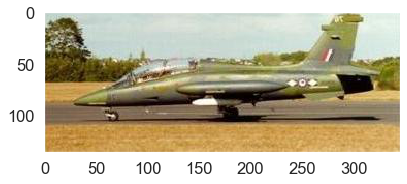

In [25]:
def average_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.mean(channel_intensities)

average_channel_intensity(training_data.Image[0], "R")
show(training_data.Image[0])

In [26]:
def aspectratio(image):
    """
    Returns the aspect ratio of the image (width/height)
    """
    return len(image[0])/len(image)

aspectratio(training_data.Image[0])

2.5441176470588234

##### Exploring the use of color histograms
A color histogram represents the distribution of colors in an image. Our motivation to try this is that different images will have different color distribution. For instance, an image of an airplane on a runway will typically have more dark colors than a leopard on the savannah. So their different color distribution seems like a useful feature to include. Also, it can especially be a helpful feature to distinguish between images where the main object is similar, but the background differs. For instance, an image of a bear in the woods and an image of a teddybear in a bed would seem quite similar when only considering the main object (the bear and the teddybear), but when also considering the background it becomes easier to distinguish the two. 

Here we will explore the use of color histograms, first for gray-scaled images, then for images with RGB-tuples. We will use the cv2.calcHist function from OpenCV to build our histograms.

In [27]:
def get_grayed_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

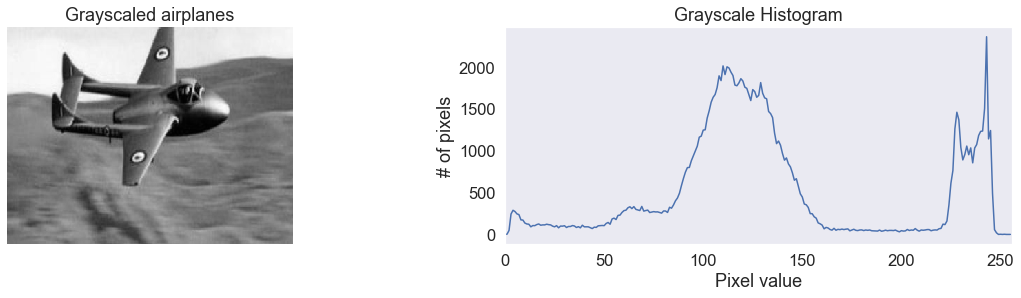

In [28]:
def get_gray_histogram(image):
    """
    cv2.calcHist(images, channels, mask, histSize, ranges)
    # images: list of images we want to compute histogram for
    # channels: list of indexes, specifies the index of the channel we want to compute the histogram for
    For a gray scaled this is [0], for RGB-image this is [0, 1, 2]
    # mask: does not use this
    # histSize: number of bins to use. Must be specified for each channel.
    Here we use 256 bins
    # ranges: possible pixle values, normally between 0 and 256.
    """
    # Convert to grayscale
    grayed_img = get_grayed_image(image)
    return cv2.calcHist([grayed_img], [0], None, [256], [0, 256])

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)

# Showing the grayed image
image_with_label = training_data.loc[mo, ['Scaled_Image', 'Label']]
image, label = image_with_label['Scaled_Image'], image_with_label['Label']

axes[0].imshow(get_grayed_image(image), cmap='gray')
axes[0].title.set_text(f'Grayscaled {label_dict[label]}')
axes[0].axis('off')

hist = get_gray_histogram(image)
hist = hist.flatten()

# Plotting the distribution
plt.title('Grayscale Histogram')
plt.xlabel('Pixel value')
plt.ylabel('# of pixels')
plt.xlim(0, 256)
axes[1].plot(hist);


As we can see, the histogram detects a large number of very dark picture (pixel values 0 to ~40), and then many medium dark pixels and very few very light pixels.

Computing a histogram for each color:

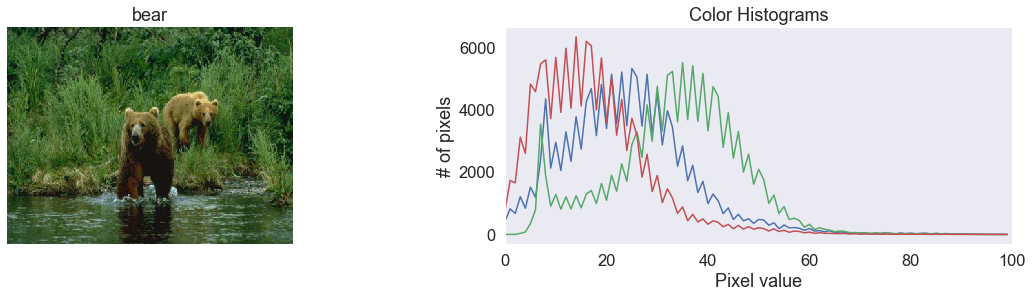

In [29]:
def get_color_histograms(image):
    channels_values = cv2.split(image)
    colors = ("b", "g", "r") # cv2 splits in reverse order 
    hist_list = []
    for (channel, color) in zip(channels_values, colors):
        #Creating a histogram for the current histogram, combining them later
        hist = cv2.calcHist([channel], [0], None, [100], [0, 256])
        hist_list.append(hist)

    return hist_list

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)
img = training_data.loc[80, 'Scaled_Image']

axes[0].imshow(img)
axes[0].axis("off")
axes[0].title.set_text(label_dict[training_data.loc[80, 'Label']])
histograms = get_color_histograms(img)

# Plotting the distribution
plt.title('Color Histograms')
plt.xlabel('Pixel value')
plt.ylabel('# of pixels')
plt.xlim(0, 100)
colors = ['b', 'g', 'r']
for i, hist in enumerate(histograms):  
    axes[1].plot(hist, color=colors[i]);

So far we computed histograms for one color (channel) at the time. To get better features we now compute multi-dimensional histograms. This will give us more informative features that looks at the combination of all three colors. For instance, we now will get a count for how many pixels has a red value of 10, a green value of 30 and a blue value of 60.

Here we use 8 bins for each channel, which results in a feature vector of size 8x8x8 = 512.
This means that one of the bins will count the number of pixels in an image that has red values 0-32, green values 0-32 and blue values 0-32, one bin will count the number of pixels that has red values 0-32, green values 0-32 and blue values 33-64, and so on.  

Computing a 3D histogram:

In [30]:
def get_3D_color_histogram(image, num_bins=8):
    """
    Extracting a 3D color histogram for the RGB (Red, Green, Blue) space using 8 bins for each of these channels
    """
    bins = [num_bins]*3
    #print(image)
    hist = cv2.calcHist([image], [0,1,2], None, bins, [0,256,0,256,0,256])
    #cv2.normalize(hist, hist)
    return hist.flatten()


img = training_data.loc[80, 'Scaled_Image']
histograms = get_color_histograms(img)
mult_dim_histograms = get_3D_color_histogram(img)
print(f"# of features of 3D color histogram for one image: {mult_dim_histograms.shape}")

# of features of 3D color histogram for one image: (512,)


In [31]:
def add_hist_features(df, column):
    """
    Method for computing 3d histograms for column in dataframe, 
    and adding the resulting feature vector as columns in the dataframe
    """
    hist_features = df[column].apply(lambda l: get_3D_color_histogram(l))
    hist_features = np.array([feat for feat in hist_features])
    prefix= 'hist_feat_'
    for i in range(len(hist_features[0])):
        feat_name = prefix+str(i)
        df[feat_name] = hist_features[:,i]

#### Average channel-intensities of image strides

Motivation: Lorem Ipsum

In [32]:
def calculate_stride_channel_averages(image):
    """
    Sliding non-overlapping strides over the image and calculating the average channel intensities for each stride
    Returning the flattened matrix containing the average RGB values for each stride.
    """

    no_width_strides = 8
    height, width = len(image), len(image[0])#scaling_size
    stride_length = width // no_width_strides
    stride_channel_avgs = []
    for i in range(no_width_strides - 1):
        height_start, height_end = stride_length * i, stride_length * (i+1)
        for j in range(no_width_strides - 1):
            width_start, width_end = stride_length * j, stride_length * (j+1)

            pixels = image[height_start : height_end][:, width_start : width_end]
            pixels = pixels.reshape(-1, pixels.shape[-1])
            r = np.mean(pixels[:, 0])
            g = np.mean(pixels[:, 1])
            b = np.mean(pixels[:, 2])

            stride_channel_avgs.append([r, g, b])

    return np.array(stride_channel_avgs).flatten()



#calculate_stride_channel_averages(training_data["Scaled_Image"][1])

In [52]:
def add_stride_features(df, column):
    """
    Method that computes average channel intensities for each stride for one column in dataframe, 
    and adding the resulting feature vector as columns in the dataframe
    """
    stride_features = df[column].apply(lambda l: calculate_stride_channel_averages(l))
    stride_features = np.array([feat for feat in stride_features])
    prefix= 'stride_feat_'
    for i in range(len(stride_features[0])):
        feat_name = prefix+str(i)
        df[feat_name] = stride_features[:,i]
    
add_stride_features(training_data, 'Scaled_Image')
training_data.head(2)

,Image_Id,Image,Label,size,Scaled_Image,stride_feat_0,stride_feat_1,stride_feat_2,stride_feat_3,stride_feat_4,...,stride_feat_137,stride_feat_138,stride_feat_139,stride_feat_140,stride_feat_141,stride_feat_142,stride_feat_143,stride_feat_144,stride_feat_145,stride_feat_146
0,0,"[[[202, 211, 208], [198, 209, 205], [195, 207,...",1,195816,"[[[202, 211, 208], [199, 209, 206], [196, 208,...",155.730873,159.953479,137.096117,201.536332,216.763552,...,95.639216,211.600000,167.547059,94.454902,212.356863,166.615686,92.345098,218.149020,178.200000,108.119608
1,1,"[[[254, 254, 226], [253, 253, 225], [253, 253,...",1,221352,"[[[254, 254, 226], [253, 253, 225], [253, 253,...",253.320646,245.307190,222.247213,247.114571,236.998462,...,190.194118,219.172549,210.162745,179.168627,203.772549,194.776471,164.545098,189.621569,180.617647,150.433333


#### Grayscale Intensity of Image

In [33]:
def grayscale_intensity(image):
    """
    Calculating the average grayscale intensity for all pixels given an image
    """
    grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(grayscaled_image)

print("Airplane:", grayscale_intensity(training_data["Scaled_Image"][1]))
print("Comet:", grayscale_intensity(training_data["Scaled_Image"][33]))

Airplane: 173.08498551166693
Comet: 121.11080524630167


#### SIFT - Scale Invariant Feature Transform

SIFT is a method for images' extracting feature vectors that describe local patches. These features are scale-invariant, as well as invariant to transaltion, rotation and illumination. Therefore we have chosen this to be a good descriptor of our images.

We are using a slightly adjusted version of Sam Lerner's implementation of SIFT (since OpenCV has removed their SIFT-implementation from the default version). The article with the proposed implementation is cited in the Sources-section below.

In [47]:
from PySIFT.sift import SIFT

In [48]:
errors = []
def sift_keypoints_and_radiuses(image, limit=100):
    global error
    sift = SIFT(image)
    kps = sift.get_keypoints()
    kps_coor, radiuses = [], []
    try:
        for kp in kps:
            kps_coor.extend(kp[:, 0:2])
            radiuses.extend(kp[:,2])
    except:
        print("error", kp)
        errors.append(image)

    return len(kps_coor)


"""
#sift_keypoints_and_radiuses(training_data["Scaled_Image"][2].copy())
display(training_data["Scaled_Image"].apply(sift_keypoints_and_radiuses).describe())

n = len(errors)
f = plt.figure()
for i in range(n):
    # Debug, plot figure
    f.add_subplot(1, n, i + 1)
    plt.imshow(errors[i])

plt.show(block=True)
"""

'\n#sift_keypoints_and_radiuses(training_data["Scaled_Image"][2].copy())\ndisplay(training_data["Scaled_Image"].apply(sift_keypoints_and_radiuses).describe())\n\nn = len(errors)\nf = plt.figure()\nfor i in range(n):\n    # Debug, plot figure\n    f.add_subplot(1, n, i + 1)\n    plt.imshow(errors[i])\n\nplt.show(block=True)\n'

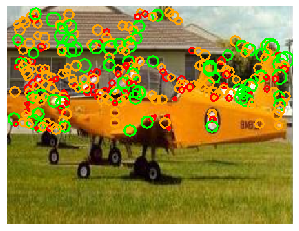

In [49]:
from sklearn.preprocessing import MinMaxScaler


img = training_data["Scaled_Image"].iloc[3].copy()
sift = SIFT(img)
kps = sift.get_keypoints() # [[x,y,s, offset]...]
desc = np.array(sift.get_features()) # [float64, ...]

radiuses = []
for kp in kps:
    radiuses.extend(kp[:,2])

# Normalize radiuses
min_max_scaler = MinMaxScaler()
radiuses_norm = min_max_scaler.fit_transform(np.reshape(radiuses, (-1, 1)))[:,0]
rad_desc = pd.Series(radiuses_norm).describe()

colors = [(255,0,0), (255,165,0), (0,255,0)]
used_colors = []

i, limit = 0, 200
for partition in kps:
    for kp in partition:
        s = radiuses_norm[i]
        rgb = colors[0] if s < rad_desc["25%"] else colors[1] if s < rad_desc["75%"] else colors[2]
        used_colors.append(rgb)
        color = int(radiuses_norm[i]*255)
        cv2.circle(img, (int(kp[0]),int(kp[1])), int(12*s), rgb, 2)
        i += 1
        if i == limit:
            break


plt.imshow(img)
plt.axis("off");

 We expect all external sources sited, and significant indication of EDA. 

<h4> Graphs </h4>

<h4> Sources </h4>

* https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/
* Averaging colors: https://dev.to/wunk/average-color-of-an-image-vectorized-4802

* SIFT: 
   * https://www.cse.unr.edu/~bebis/CS491Y/Papers/Lowe04.pdf
   * https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
   * https://medium.com/@lerner98/
   * Source-code: https://github.com/SamL98/PySIFTimplementing-sift-in-python-36c619df7945


<h4> DataFrame Creation </h4>

In [67]:
def feature_frame(data=None, drop_images=True):
    """
    Returns preprocessed data with all features
    """
    if data is None:
        print("[INFO] Reading images")
        data, _ = read_training_data()

    scaling_size = get_scaling_size(data)
    
    print("[INFO] Trimming images")
    data['Image'] = data['Image'].apply(get_trimmed_image)
    
    print("[INFO] Scaling images")
    data["Scaled_Image"] = data["Image"].apply(lambda i: resize_image(i, scaling_size))
    
    print("[INFO] Adding features: size, aspect_ratio, red-, green-, blue- and gray-intensity")
    data['Size'] = data['Image'].apply(image_size)
    data['AspectRatio'] = data['Image'].apply(aspectratio)
    data['Red_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'R'))
    data['Green_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'G'))
    data['Blue_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'B'))
    data['Grayscale_intensity'] = data['Scaled_Image'].apply(grayscale_intensity)
    
    print("[INFO] Adding histogram features")
    add_hist_features(data, 'Scaled_Image')
    
    print("[INFO] Adding stride features")
    add_stride_features(data, 'Scaled_Image')
    
    if drop_images:
        data.drop(columns=['Image', 'Scaled_Image'], inplace=True)
    
    print("[INFO] Done preprocessing")
    return data